# The Price is Right

Today we build a more complex solution for estimating prices of goods.

1. Day 2.0 notebook: create a RAG database with our 400,000 training data
2. Day 2.1 notebook: visualize in 2D
3. Day 2.2 notebook: visualize in 3D
4. Day 2.3 notebook: build and test a RAG pipeline with GPT-4o-mini
5. Day 2.4 notebook: (a) bring back our Random Forest pricer (b) Create a Ensemble pricer that allows contributions from all the pricers

Phew! That's a lot to get through in one day!

## PLEASE NOTE:

We already have a very powerful product estimator with our proprietary, fine-tuned LLM. Most people would be very satisfied with that! The main reason we're adding these extra steps is to deepen your expertise with RAG and with Agentic workflows.

## We will go fast today! Hold on to your hat..

In [1]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from testing import Tester

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [5]:
openai = OpenAI()

In [6]:
# Load in the test pickle file
# See the section "Back to the PKL files" in the day2.0 notebook
# for instructions on obtaining this test.pkl file

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [7]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [8]:
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [9]:
DB = "products_vectorstore"

In [10]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [11]:
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [12]:
description(test[0])

'Teco 2 HP, 3600 RPM, TEFC, 145T Frame, Volt, 3 PH, Max-Pe, Footed Frame AC Electric Induction Motor\nTECO WESTINGHOUSE MAX-PE PREMIUM EFFICIENCY TEFC INVERTER DUTY MOTOR 2HP, 3600 RPM, 145T, NP0022 TECO WESTINGHOUSE MAX-PE PREMIUM EFFICIENCY TEFC INVERTER DUTY MOTOR 2HP, 3600 RPM, 145T, NP0022 62.0 LBR Brand Teco Westinghouse, Speed 3600 RPM, Horsepower 2 hp, Weight 62 Pounds, Available October 26, 2016, Manufacturer TECO WESTINGHOUSE'

In [13]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [14]:
def vector(item):
    return model.encode([description(item)])

In [15]:
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [16]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

hansgrohe Metris Modern Upgrade Easy Install 1 7-inch Tall Bathroom Sink Faucet in Brushed Nickel,
Design With a range of models and styles, paired with the quality and design you expect from hansgrohe, dream bathrooms become a reality. Bath faucets by hansgrohe exude beautiful design with superior performance and durability. Pick your desired faucet, then browse the entire product suite for complementary accessories. German engineering ensures a lifetime of consistent and dependable operation. Maintenance Products that function perfectly are essential. To ensure that they do, every hansgrohe product 100% air tested in production. hansgrohe faucets feature a silicone aerator that optimizes water flow performance, resists mineral deposit build-up, and is designed to be easily wiped clean. Installation Can be installed in existing 

Price is $278.00


In [17]:
documents, prices = find_similars(test[1])

/Users/justin/anaconda3/envs/ai/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [18]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
hansgrohe Metris Modern Upgrade Easy Install 1 6-inch Tall Bathroom Sink Faucet in Brushed Nickel,
Design With a range of models and styles, paired with the quality and design you expect from hansgrohe, dream bathrooms become a reality. Bath faucets by hansgrohe exude beautiful design with superior performance and durability. Pick your desired faucet, then browse the entire product suite for complementary accessories. German engineering ensures a lifetime of consistent and dependable operation. Maintenance Products that function perfectly are essential. To ensure that they do, every hansgrohe product 100% air tested in production. hansgrohe faucets feature a silicone aerator that optimizes water flow performance, resists mineral deposit build-up, and is designed to be easily wiped clean. Installation Can be installed in existing 
Price is $219.44

Pot

In [19]:
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nhansgrohe Metris Modern Upgrade Easy Install 1 6-inch Tall Bathroom Sink Faucet in Brushed Nickel,\nDesign With a range of models and styles, paired with the quality and design you expect from hansgrohe, dream bathrooms become a reality. Bath faucets by hansgrohe exude beautiful design with superior performance and durability. Pick your desired faucet, then browse the entire product suite for complementary accessories. German engineering ensures a lifetime of consistent and dependable operation. Maintenance Products that function perfectly are essential. To ensure that they do, every hansgrohe product 100% air tested in production. hansgrohe faucets feature a silicone aerator that optimizes water flow performance, 

In [20]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [21]:
get_price("The price for this is $99.99")

99.99

In [22]:
# The function for gpt-4o-mini

# def gpt_4o_mini_rag(item):
#     documents, prices = find_similars(item)
#     response = openai.chat.completions.create(
#         model="gpt-4o-mini", 
#         messages=messages_for(item, documents, prices),
#         seed=42,
#         max_tokens=5
#     )
#     reply = response.choices[0].message.content
#     return get_price(reply)



def gpt_4o_mini_rag(item):
    import requests
    import json
    OLLAMA_API = "http://localhost:11434/api/chat"
    HEADERS = {"Content-Type": "application/json"}
    MODEL = "gpt-oss:20b"
    documents, prices = find_similars(item)

    payload = {
        "model": MODEL,
        "messages": messages_for(item, documents, prices),
        "stream": False
    }

    response = requests.post(OLLAMA_API, headers=HEADERS, data=json.dumps(payload))
    response.raise_for_status()
    data = response.json()

    # Ollama's API returns {"message": {"role": ..., "content": ...}, ...}
    reply = data["message"]["content"]
    return get_price(reply)

1: Guess: $1,200.00 Truth: $385.97 Error: $814.03 SLE: 1.28 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $219.44 Truth: $277.91 Error: $58.47 SLE: 0.06 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $169.99 Truth: $147.33 Error: $22.66 SLE: 0.02 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $127.61 Truth: $74.99 Error: $52.62 SLE: 0.28 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $18.49 Truth: $19.99 Error: $1.50 SLE: 0.01 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $166.60 Truth: $166.60 Error: $0.00 SLE: 0.00 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $449.00 Truth: $265.00 Error: $184.00 SLE: 0.28 Item: Nest Cam IQ, Works with Alexa
8: Guess: $129.99 Truth: $165.99 Error: $36.00 SLE: 0.06 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $42.99 Truth: $69.99 Error: $27.00 SLE: 0.23 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $319.89 Truth: $319.59 Error: $0.30 SLE: 0.

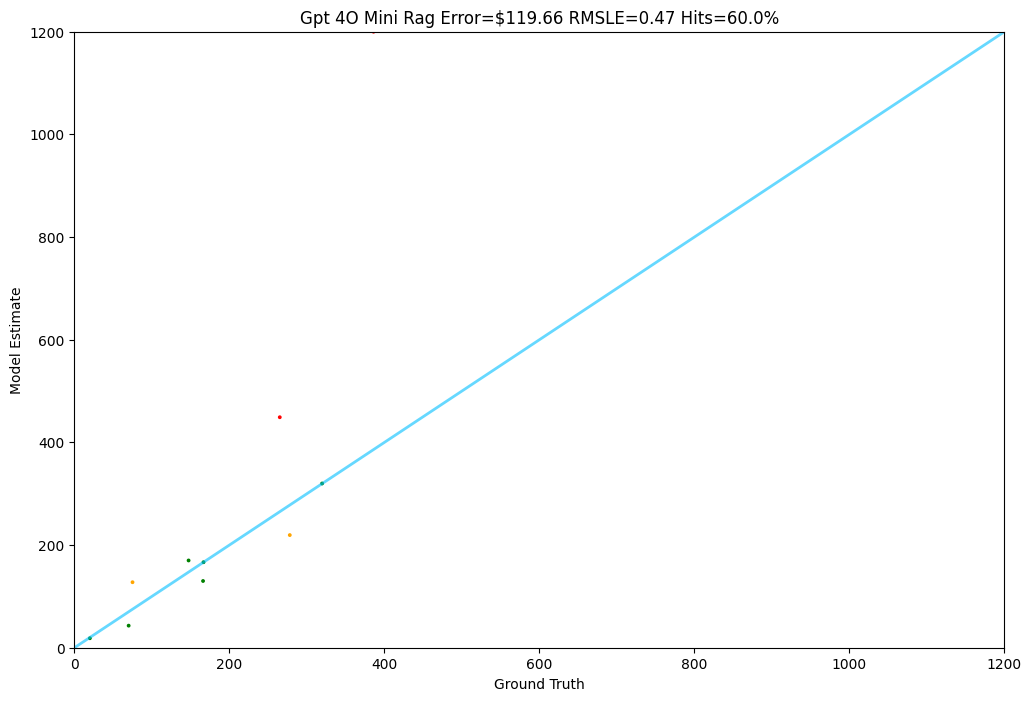

In [23]:
Tester.test(gpt_4o_mini_rag, test)

## Optional Extra: Trying a DeepSeek API call instead of OpenAI

If you have a DeepSeek API key, we will use it here as an alternative implementation; otherwise skip to the next section..

In [24]:
# Connect to DeepSeek using the OpenAI client python library

# deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
# deepseek_via_openai_client = OpenAI(api_key=deepseek_api_key,base_url="https://api.deepseek.com")

In [25]:
# Added some retry logic here because DeepSeek is very oversubscribed and sometimes fails..

# def deepseek_api_rag(item):
#     documents, prices = find_similars(item)
#     retries = 8
#     done = False
#     while not done and retries > 0:
#         try:
#             response = deepseek_via_openai_client.chat.completions.create(
#                 model="deepseek-chat", 
#                 messages=messages_for(item, documents, prices),
#                 seed=42,
#                 max_tokens=8
#             )
#             reply = response.choices[0].message.content
#             done = True
#         except Exception as e:
#             print(f"Error: {e}")
#             retries -= 1
#     return get_price(reply)

def deepseek_api_rag(item):
    import requests
    import json
    OLLAMA_API = "http://localhost:11434/api/chat"
    HEADERS = {"Content-Type": "application/json"}
    MODEL = "deepseek-r1:8b"
    documents, prices = find_similars(item)

    payload = {
        "model": MODEL,
        "messages": messages_for(item, documents, prices),
        "stream": False
    }

    response = requests.post(OLLAMA_API, headers=HEADERS, data=json.dumps(payload))
    response.raise_for_status()
    data = response.json()

    # Ollama's API returns {"message": {"role": ..., "content": ...}, ...}
    reply = data["message"]["content"]
    return get_price(reply)

1: Guess: $485.89 Truth: $385.97 Error: $99.92 SLE: 0.05 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $178.49 Truth: $277.91 Error: $99.42 SLE: 0.19 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $162.99 Truth: $147.33 Error: $15.66 SLE: 0.01 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $75.99 Truth: $74.99 Error: $1.00 SLE: 0.00 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $17.99 Truth: $19.99 Error: $2.00 SLE: 0.01 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $166.60 Truth: $166.60 Error: $0.00 SLE: 0.00 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $599.95 Truth: $265.00 Error: $334.95 SLE: 0.66 Item: Nest Cam IQ, Works with Alexa
8: Guess: $93.99 Truth: $165.99 Error: $72.00 SLE: 0.32 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $94.99 Truth: $69.99 Error: $25.00 SLE: 0.09 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $319.89 Truth: $319.59 Error: $0.30 SLE: 0.00 Ite

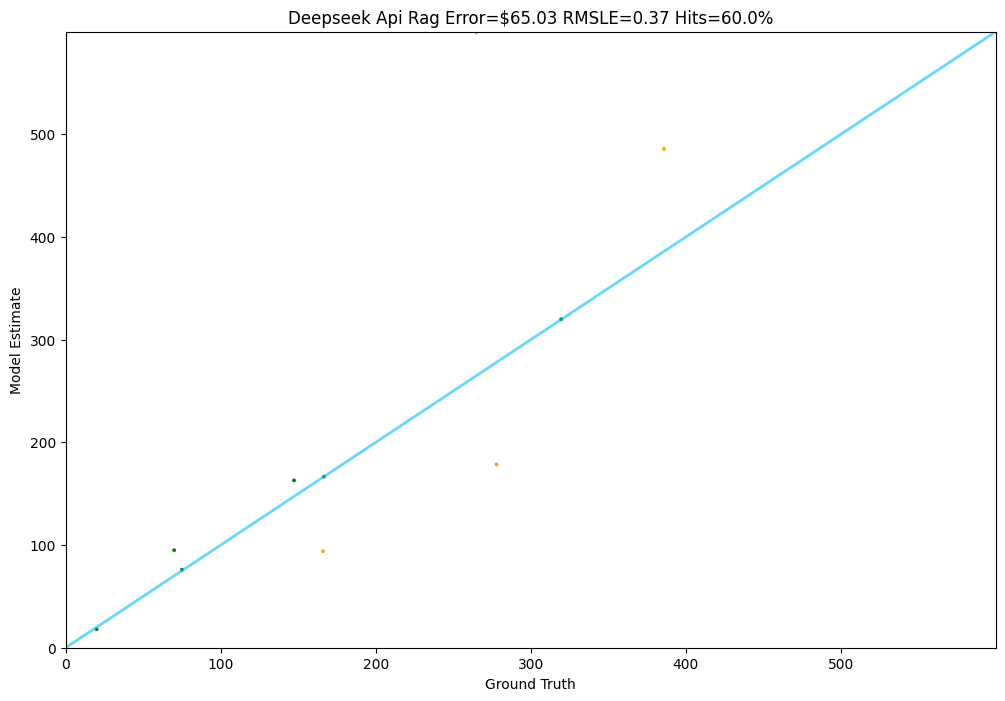

In [26]:
Tester.test(deepseek_api_rag, test)

## And now to wrap this in an "Agent" class

In [27]:
from agents.frontier_agent import FrontierAgent

In [28]:
# Let's print the logs so we can see what's going on

import logging
root = logging.getLogger()
root.setLevel(logging.INFO)

In [29]:
agent = FrontierAgent(collection)

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is set up with Gemini
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready


In [30]:
agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call gemini-2.5-flash with context including 5 similar products
INFO:httpx:HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/openai/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $150.00


150.0

In [31]:
from agents.specialist_agent import SpecialistAgent

In [32]:
agent2 = SpecialistAgent()

INFO:root:[Specialist Agent] Specialist Agent is initializing - connecting to modal
INFO:root:[Specialist Agent] Specialist Agent is ready


In [33]:
agent2.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Specialist Agent] Specialist Agent is calling remote fine-tuned model
INFO:root:[Specialist Agent] Specialist Agent completed - predicting $189.00


189.0